In [34]:
from sentence_transformers import SentenceTransformer
from matplotlib import pyplot as plt
import pandas as pd
import sys
import os 
import torch.nn.functional as F
from transformers import AutoTokenizer, TrainingArguments, EsmForMaskedLM, Trainer
from pathlib import Path
import torch.nn.functional as F
import torch.nn as nn

from deap import base, creator, tools, algorithms
import random
import numpy as np
from Levenshtein import distance
from sklearn.metrics import r2_score

In [3]:
class EsmWithRegression(EsmForMaskedLM):
    def __init__(self, config):
        super().__init__(config)
        self.regression_head = nn.Linear(config.hidden_size, EMB_FEATURES)
        self.log_sigma_mlm = nn.Parameter(torch.tensor(0.0))
        self.log_sigma_regression = nn.Parameter(torch.tensor(0.0))

    def forward(self, input_ids=None, attention_mask=None, labels=None, regression_labels=None, **kwargs):
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, labels=labels, **kwargs)
        last_hidden_state = outputs.hidden_states[-1]
        # mean_pooled = (last_hidden_state * attention_mask.unsqueeze(-1)).sum(dim=1) / attention_mask.sum(dim=1, keepdim=True)
        mean_pooled = last_hidden_state[:, 0, :]
        regression_logits = self.regression_head(mean_pooled)

      
        return {
        
            "logits": outputs.logits,
            "regression_logits": regression_logits,
            "regression_labels": regression_labels
        }


# model = EsmWithRegression.from_pretrained(modelname, output_hidden_states=True)


def load_model(base_model_path, peft_model_path,only_raw_model = False):
    """
    Load the fine-tuned model and tokenizer from the given local path.
    """
    base_path = Path(base_model_path)
    model_path = Path(peft_model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
    if not only_raw_model:
       
        #method 2
        model = EsmWithRegression.from_pretrained(base_model_path, local_files_only=True)
        model.load_adapter(peft_model_path)
        # print('loading the finetuned model')
    else:
        model = EsmWithRegression.from_pretrained(base_model_path, local_files_only=True)
        # model = EsmForSequenceClassification.from_pretrained("facebook/esm2_t6_8M_UR50D")
        # print('loading the raw model')
        
    model.eval()  # Set the model to evaluation mode
    return model, tokenizer

def predict_sequence(model, tokenizer, sequence, max_length=512, to_cuda = True):
    """
    Predict the class of the given sequence using the fine-tuned model.
    """
    # Preprocess the input sequence
    inputs = tokenizer(sequence, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    if to_cuda:
        inputs.cuda()
    # Make prediction
    with torch.no_grad():
        outputs = model(**inputs)
       
    return outputs





In [4]:
sys.path.insert(0,'/home/salaris/protein_model/')


In [5]:
base_model = "/home/salaris/protein_model/function_prediction/protein_model/model/esm2_t6_8M_UR50D_base_model_accelerated"
# finetuned_model = "/home/salaris/protein_model/function_prediction/protein_model/model/esm_finetuned_accelerated/deep-totem-10/"
# finetuned_model = "/home/salaris/protein_model/function_prediction/protein_model/model/esm_finetuned_accelerated/volcanic-cherry-11/"
# finetuned_model = "/home/salaris/protein_model/function_prediction/protein_model/model/esm_finetuned_accelerated/snowy-snowflake-13/"
# finetuned_model = "/home/salaris/protein_model/function_prediction/protein_model/model/esm_finetuned_accelerated/sleek-tree-17/"
finetuned_model = "/home/salaris/protein_model/function_prediction/protein_model/model/esm_finetuned_accelerated/still-tree-30/"

In [6]:
from functions import EmbeddingEncoder
import torch
EMB_FEATURES = 384
model,tokenizer = load_model(base_model,peft_model_path=finetuned_model)

modelname = 'tavakolih/all-MiniLM-L6-v2-pubmed-full'
# model = SentenceTransformer(modelname)


In [7]:
# model

In [8]:
st_model = EmbeddingEncoder(modelname)
emb =st_model.encode('hi')

/home/salaris/.conda/envs/cuda_torch/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
# sequence0 = list("KMKIEFSTGCIPISSLFMSIIKEKEKNNKKTKNFTFSVYIKKYSIEGDNFIIEDVILNISTPDLELGFHIYNGLTS")
# sequence1 = sequence0.copy()
# sequence1[10] = '<mask>'
# sequence1[61] = '<mask>'

# sequence = ["".join(sequence0),"".join(sequence1)]
# xx= predict_sequence(model,tokenizer,sequence,max_length=1024,to_cuda=False)


In [10]:
# A = xx['logits'][0].argmax(-1)
# B = xx['logits'][1].argmax(-1)
# plt.plot(A,'x')
# plt.plot(B,'*')


In [11]:

# predicted_token_ids = xx['logits'].argmax(-1)
# predicted_sequences = [
#         tokenizer.decode(token_ids, skip_special_tokens=True) 
#         for token_ids in predicted_token_ids
#     ]
# list(sequence),predicted_sequences[1]

In [12]:
# plt.plot(xx['regression_logits'][0])
# plt.plot(xx['regression_logits'][1])

In [13]:
output_file = '/home/salaris/protein_model/function_prediction/data/prot_func.tsv'

all_data = pd.read_csv(output_file,sep = "\t", nrows = 10000)


In [36]:
#lets pick something:
p = -1
while p <100:
    try:
        candidate = all_data.sample(1).iloc[0]
        p = 1000
    except:
        print('failed')
        p = p + 1
# reference_embedding= emb =st_model.encode(candidate.go)
candidate.sequence


'MNRDLQELPRFDENWSYLYFEKGHIEQDMQTVAYFYKDKKVPIPAETLSLLMLGPGTTITHAAIKRLTDARCLLCWVGDEGVRMYSAGTQGTYSSRNLLRQAQLYSDPEERLRVVRKLYEMRFDEVVDERYSIEQLRGKEGARVRAAYKAAAEEYEIEWTGRNYDQSEWGISDPINKALSAANSCLYGLCHAAILAVGCSAGIGFIHTGKQLSFVYDLADLYKTELTIPIAFRIAQGPASVESRVRMECRDVFKERKLLKRIIPDIMEVLYGNRRAGESDAGSEGRDVAVNY'

(384,)


Text(0.5, 1.0, '-0.14195024967193604')

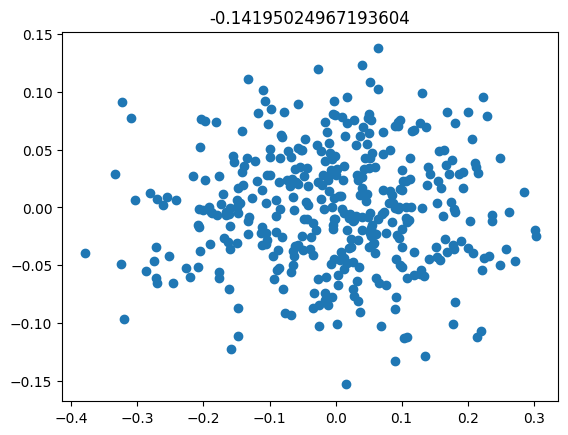

In [46]:

candidate_embedding = st_model.encode(candidate.go)
print(candidate_embedding.shape)
# candidate_embedding
xx = predict_sequence(model,tokenizer,candidate.sequence, max_length=512,to_cuda=False)['regression_logits']
plt.scatter(xx,candidate_embedding)
plt.title(r2_score(np.array(xx)[-1,:],candidate_embedding))

In [ ]:
from deap import base, creator, tools, algorithms
import random
import numpy as np
from Levenshtein import distance
from sklearn.metrics import r2_score
# Your specific starting sequence and positions to mutate

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'



starting_sequence = candidate.sequence
sequence_length = len(starting_sequence)


print('starting sequence length:', len(starting_sequence))

positions_to_mutate = range(0,sequence_length,50)  # example positions
# positions_to_mutate = range(sequence_length)
# mutate some random positions 
ss = list(starting_sequence)
for position in positions_to_mutate:
    ss[position] = random.choice(amino_acids)
starting_sequence = "".join(ss)
print(starting_sequence)



# Define the fitness function
def fitness_function(sequence,model,tokenizer,candidate_embedding):
    # print(sequence)
    xx = predict_sequence(model,tokenizer, "".join(sequence), max_length = 512, to_cuda= False)['regression_logits']
    # print(xx.shape, candidate_embedding.shape)
    return(r2_score(xx.cpu().numpy().reshape(-1),candidate_embedding),)
# Define the sequence creator
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)



# Initialization of the population
toolbox = base.Toolbox()

# Define a generator function for new individuals
def generate_individual():
    return creator.Individual(list(starting_sequence))

toolbox.register("individual", generate_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Custom mutation function
def custom_mutate(individual):
    for position in positions_to_mutate:
        # Randomly select a new amino acid for the position
        individual[position] = random.choice('ACDEFGHIKLMNPQRSTVWY')
    return individual,

# Operators
toolbox.register("evaluate", fitness_function,**{'model':model, 'tokenizer':tokenizer, 'candidate_embedding': candidate_embedding})
toolbox.register("mate", tools.cxUniform, indpb=0.1)  # Uniform crossover
toolbox.register("mutate", custom_mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

# Genetic Algorithm
def main():
    pop0 = toolbox.population(n=50)  # n is the number of individuals
    hof = tools.HallOfFame(1, similar=lambda x, y: x == y)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(pop0, toolbox, cxpb=0.5, mutpb=0.2, ngen=380, stats=stats, halloffame=hof, verbose=True)  # ngen is the number of generations

    return pop, log, hof,pop0,stats

# if __name__ == "__main__":
#     main()


In [ ]:
[p for p in positions_to_mutate]

In [ ]:
test_embedding = st_model.encode(starting_sequence)
r2_score(test_embedding, candidate_embedding)

In [ ]:
pop , log , hof,pop0,stats = main()

In [ ]:
a = starting_sequence
a

In [ ]:
best ="".join(hof.items[0])

In [ ]:
ss =  candidate.sequence
ss

In [ ]:
distance(ss,best)

In [ ]:
distance(ss,starting_sequence)

In [ ]:
pop0 = toolbox.population(n=300)
a = "".join(pop0[0])
a

In [ ]:
star